In [405]:
import torch
import torch.nn as nn
import torch.optim as optim
from oil.model_trainers.classifierTrainer import ClassifierTrainer
from oil.model_trainers.svrgTrainer3 import SVRGTrainer
from oil.datasetup.datasets import CIFAR10, C10augLayers
from oil.datasetup.dataloaders import getUnlabLoader, getLabLoader
from oil.architectures.networkparts import layer13,ConvSmallNWN
from oil.utils.utils import cosLr, loader_to
from oil.extra.SVRG import SVRG
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [407]:
train_epochs = 25
problem_config =    {'numClasses':500,'numFeatures':500,'dataset_size':10000}
loader_config =     {'batch_size':100}
opt_config =        {'lr':.03, 'momentum':.9, 'weight_decay':1e-7, 'nesterov':True}
sched_config =      {'cycle_length':train_epochs,'cycle_mult':1}
trainer_config =    {'log_args':{'no_print':True, 'minPeriod':0, 'timeFrac':4/10}}

trainer_config['log_dir'] = '/home/maf388/tb-experiments2/convex_toy'
trainer_config['description'] = 'Convex Problem, SGD'

In [408]:
device = torch.device('cuda')
N,D,C = problem_config['dataset_size'], problem_config['numFeatures'], problem_config['numClasses']
x = torch.randn(N, D)
y_logits = x.matmul(D/10. * torch.rand(D, C)) + 0.3 * torch.randn(N, C)
y = torch.distributions.Categorical(logits=y_logits).sample()

dataset = torch.utils.data.TensorDataset(x.to(device), y.to(device))
dataloaders = {}
dataloaders['train'] = torch.utils.data.DataLoader(dataset,shuffle=True, **loader_config)

In [409]:
def makeSGDTrainer():
    model = nn.Linear(D,C).to(device)
    opt_constr = lambda params: optim.SGD(params, **opt_config)
    lr_sched = lambda e:32#cosLr(**sched_config)
    return ClassifierTrainer(model, dataloaders, opt_constr, lr_sched, **trainer_config)

In [410]:
def makeSVRGTrainer():
    model = nn.Linear(D,C).to(device)
    opt_constr = lambda params: SVRG(params, **opt_config)
    lr_sched = lambda e:16#cosLr(**sched_config)
    return SVRGTrainer(model, dataloaders, opt_constr, lr_sched, **trainer_config)

In [411]:
sgdTrainer = makeSGDTrainer()
sgdTrainer.train(train_epochs)

HBox(children=(IntProgress(value=0, max=25), HTML(value='')))

In [412]:
svrgTrainer = makeSVRGTrainer()
svrgTrainer.train(train_epochs)

HBox(children=(IntProgress(value=0, max=25), HTML(value='')))

Text(0,0.5,'Loss')

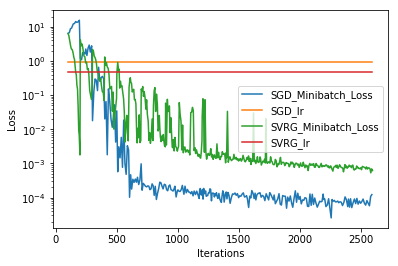

In [309]:
k = 5000
ax = sgdTrainer.logger.scalar_frame.loc[:k].add_prefix('SGD_').plot()
svrgTrainer.logger.scalar_frame.loc[:k].add_prefix('SVRG_').plot(ax=ax)
ax.set_yscale('log')
ax.set_xlabel('Iterations')
ax.set_ylabel('Loss')